# Strategies trading results comparison

In [1]:
%%capture
%pip install plotly==5.9.0
%pip install twisted
%pip install binance-connector==1.13.0
%pip install pandas 
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

## Download trading data
Download the data from cloud, read strategies databases for analysis

In [2]:
import os
strategies=["SimpleKerasStrategy", "LSTMStrategy", "LSTMStrategy2"]
os.system("cd ./../deploy/yandex_cloud; ./download_data.sh")
print(f"Download completed.")

rsync -v -r yc-user@51.250.12.103:/home/yc-user/biml/data/ /home/dima/projects/biml/deploy/yandex_cloud/../../data/yandex-cloud
receiving incremental file list
LSTMStrategy/LSTMStrategy.db
LSTMStrategy/Xy/2023-05-23_BTCUSDT_X.csv
LSTMStrategy/Xy/2023-05-23_BTCUSDT_data.csv
LSTMStrategy/Xy/2023-05-23_BTCUSDT_y.csv


file has vanished: "/home/yc-user/biml/data/LSTMStrategy/weights/2023-05-23T20:19:05.915606.data-00000-of-00001"
file has vanished: "/home/yc-user/biml/data/LSTMStrategy/weights/2023-05-23T20:19:05.915606.index"
file has vanished: "/home/yc-user/biml/data/LSTMStrategy2/weights/2023-05-23T20:19:16.394110.data-00000-of-00001"
file has vanished: "/home/yc-user/biml/data/LSTMStrategy2/weights/2023-05-23T20:19:16.394110.index"


LSTMStrategy/weights/checkpoint
LSTMStrategy2/LSTMStrategy2.db
LSTMStrategy2/Xy/2023-05-23_BTCUSDT_X.csv
LSTMStrategy2/Xy/2023-05-23_BTCUSDT_data.csv
LSTMStrategy2/Xy/2023-05-23_BTCUSDT_y.csv
LSTMStrategy2/weights/checkpoint
SimpleKerasStrategy/SimpleKerasStrategy.db
SimpleKerasStrategy/Xy/2023-05-23_BTCUSDT_X.csv
SimpleKerasStrategy/Xy/2023-05-23_BTCUSDT_data.csv


file has vanished: "/home/yc-user/biml/data/SimpleKerasStrategy/weights/2023-05-23T20:19:01.046782.data-00000-of-00001"
file has vanished: "/home/yc-user/biml/data/SimpleKerasStrategy/weights/2023-05-23T20:19:01.046782.index"


SimpleKerasStrategy/Xy/2023-05-23_BTCUSDT_y.csv
SimpleKerasStrategy/weights/checkpoint

sent 434,557 bytes  received 1,593,200 bytes  37,206.55 bytes/sec
total size is 932,686,067  speedup is 459.96
Download completed.


rsync warning: some files vanished before they could be transferred (code 24) at main.c(1684) [generator=3.1.3]


In [3]:
import pandas as pd
import numpy as np
import sqlite3

def get_trades(strategy: str):
    """ Read strategy trades from related sqlite3 database"""
    data_dir=f"../data/yandex-cloud"

    db_path=f"{data_dir}/{strategy}/{strategy}.db"
    print(f"Get {strategy} trades from {db_path}")

    with sqlite3.connect(db_path) as conn:
        trades=pd.read_sql_query("SELECT * FROM trade ORDER BY open_time",conn,
                                 parse_dates=["open_time", "close_time"])#.set_index("open_time", drop=False)
    trades["profit"] = np.where(trades["side"] == "BUY", 
                                (trades["close_price"]-trades["open_price"])*trades["quantity"],
                                (trades["open_price"]-trades["close_price"])*trades["quantity"],
                               )
    trades["cum_profit"] = trades["profit"].cumsum()
    open_time=trades["open_time"].iloc[-1]    
    close_time=trades["close_time"].iloc[-1]    
    print(f"{strategy} last trade open: {open_time}, close: {close_time}\n")  
    
    return trades

# Main data structure: strategy -> trades dictionary
strategies_trades = dict([(strategy, get_trades(strategy)) for strategy in strategies])


Get SimpleKerasStrategy trades from ../data/yandex-cloud/SimpleKerasStrategy/SimpleKerasStrategy.db
SimpleKerasStrategy last trade open: 2023-05-23 20:07:45.491000, close: 2023-05-23 20:09:30.168000

Get LSTMStrategy trades from ../data/yandex-cloud/LSTMStrategy/LSTMStrategy.db
LSTMStrategy last trade open: 2023-05-23 20:01:25.207000, close: 2023-05-23 20:07:10.442000

Get LSTMStrategy2 trades from ../data/yandex-cloud/LSTMStrategy2/LSTMStrategy2.db
LSTMStrategy2 last trade open: 2023-05-23 20:15:58.234000, close: 2023-05-23 20:17:47.208000



## Cumulative profit

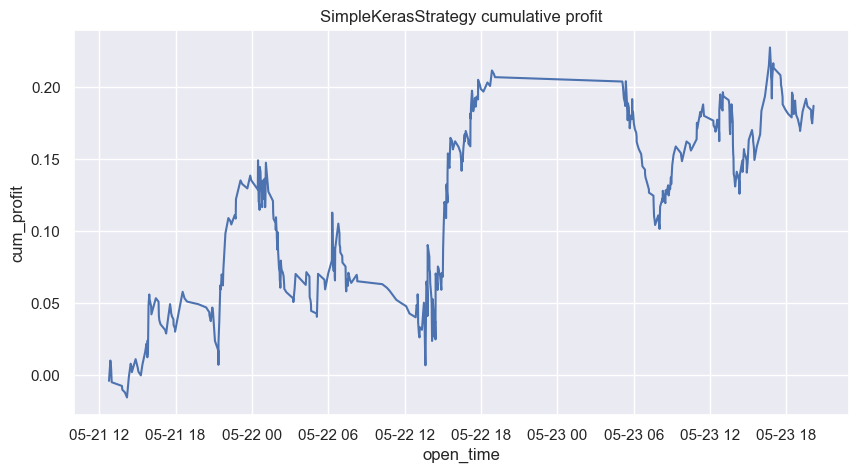

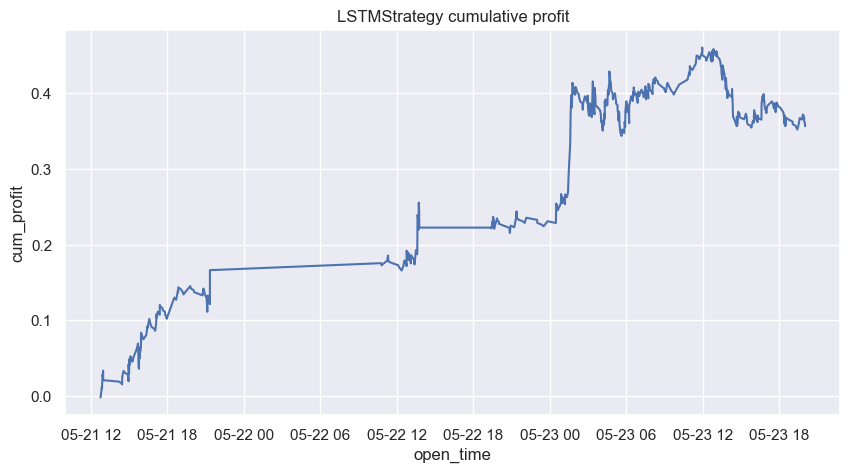

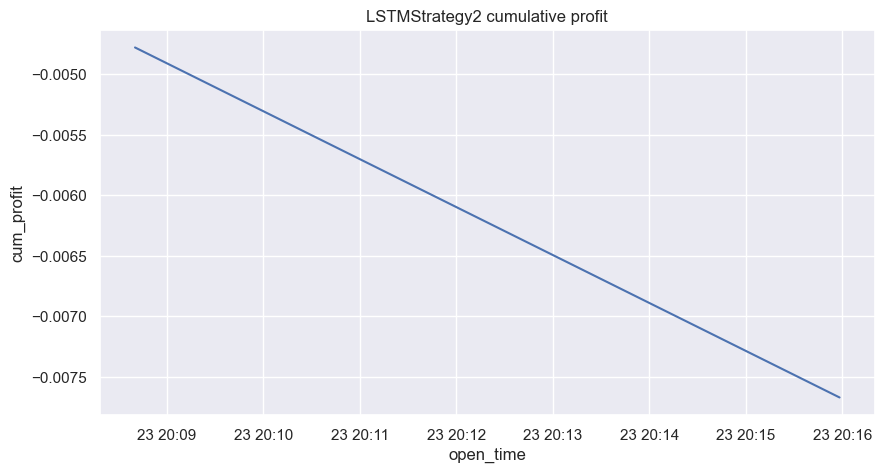

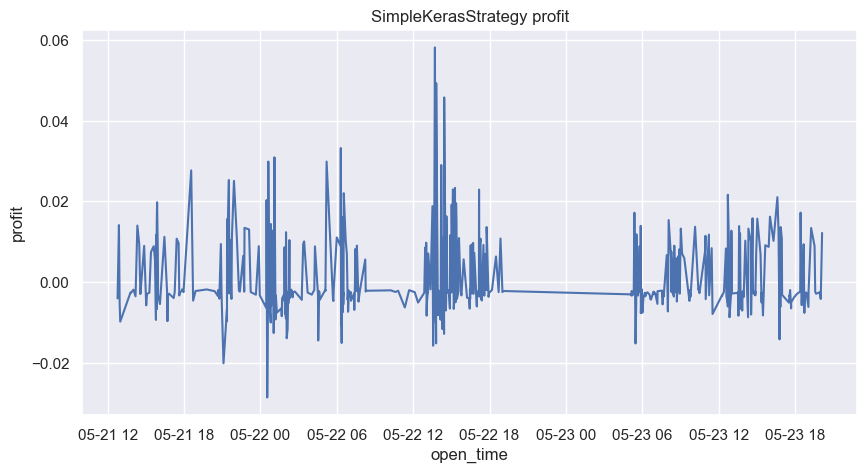

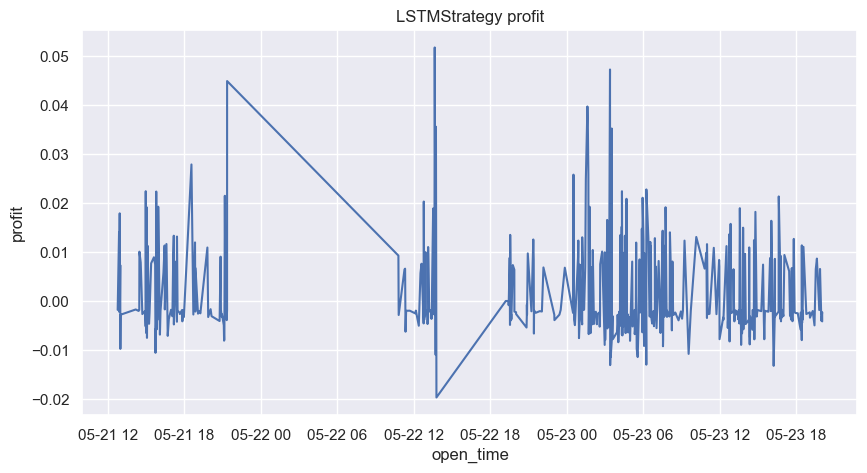

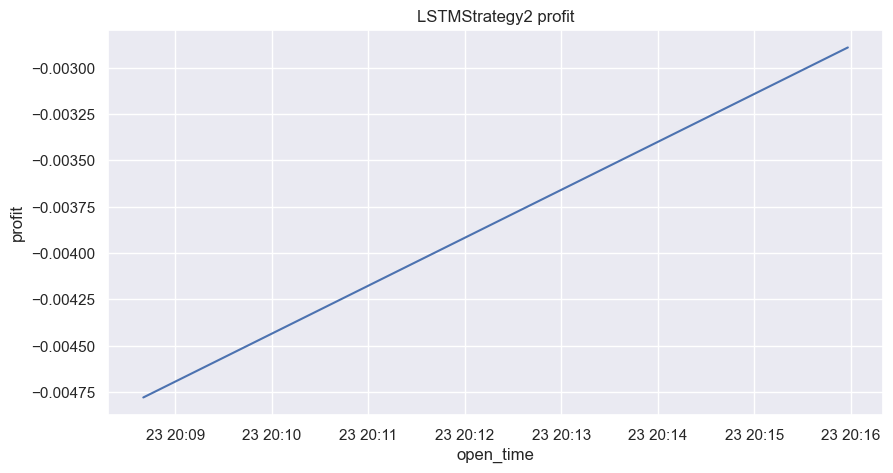

In [4]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set_theme()
#paper, notebook, talk, poster

import plotly.graph_objs as go
import plotly.io as pio
from plotly.subplots import make_subplots
pio.renderers.default = "plotly_mimetype+notebook"
import plotly.graph_objects as go

# Align the plot width    
plot_figsize=(10,5)
sns.set_style("darkgrid")


def plot_profit_plotly(strategy, trades):
    """ Plot strategy profit using plotly"""
    px.line(trades, x="open_time", y="profit", title=f"{strategy} profit").update_traces(mode='lines+markers').show()
    
def plot_cum_profit_plotly(strategy, trades):
    """ Plot strategy um profit using plotly"""
    px.line(trades, x="open_time", y="cum_profit", title=f"{strategy} cumulative profit").update_traces(mode='lines+markers').show()

def plot_profits_plotly(strategy, trades):
    """ Plot strategy profit and cum profit using plotly"""
    plot_profit_plotly(strategy, trades)
    plot_cum_profit_plotly(strategy, trades)
    
def plot_profit_sns(strategy, trades):
    """ Plot strategy profit using sns"""
    plt.figure(figsize=plot_figsize)
    sns.lineplot(data=trades, x="open_time", y="profit").set_title(f"{strategy} profit")
    plt.show()

def plot_cum_profit_sns(strategy, trades):
    """ Plot strategy cum profit using sns"""
    #sns.set_palette("deep")
    plt.figure(figsize=plot_figsize)
    sns.lineplot(data=trades, x="open_time", y="cum_profit").set_title( f"{strategy} cumulative profit")
    plt.show()

def plot_cum_filtered_profit_sns(strategy, trades):
    """ Plot strategy profit without outliers using sns"""
    # Cumulative profit w/o outliers
    profit=trades[["open_time","profit"]].set_index("open_time")
    q_low = profit["profit"].quantile(0.1)
    q_hi  = profit["profit"].quantile(0.9)
    profit_filtered = profit[(profit["profit"] < q_hi) & (profit["profit"] > q_low)]
    cumsum_filtered = profit_filtered.cumsum()
    plt.figure(figsize=plot_figsize)
    sns.lineplot(data=cumsum_filtered).set_title(f"{strategy} profit w/o outliers")
    plt.show()

def plot_profits_sns(strategy, trades):
    """ Plot strategy profit and cum profit using plotly"""
    plot_profit_sns(strategy, trades)
    plot_cum_profit_sns(strategy, trades)
    plot_cum_filtered_profit_sns(strategy, trades)
    

def plot_profit_plt(strategy, trades):
    """ Plot profits using matplotlib """
    plt.figure(figsize=(10,5))
    plt.plot("open_time", "profit", data=trades)
    plt.title(f"{strategy} profit")
    plt.show()
    
def plot_cum_profit_plt(strategy, trades):
    """ Plot strategy cum profit using matplotlib"""
    
    sns.set_style("darkgrid")
    plt.figure(figsize=(10,5))
    plt.plot("open_time", "cum_profit", data=trades)
    plt.title(f"{strategy} cumulative profit")
    plt.show()

def plot_profits_plt(strategy, trades):
    """ Plot strategy profit and cum profit using matplotlib"""
    plot_profit_plt(strategy, trades)
    plot_cum_profit_plt(strategy, trades)
    
    
def plot_strategies_profits(plot_func, strategies_trades):
    """ Plot all strategies profit using given func"""
    
    for strategy in strategies:
        trades=strategies_trades[strategy]
        plot_func(strategy, trades)
        #plot_cum_profit_plt(strategy, trades)
    
# Plot cumulative profit for each strategy
plot_strategies_profits(plot_cum_profit_sns, strategies_trades)
plot_strategies_profits(plot_profit_sns, strategies_trades)


## Buy, sell trade counts

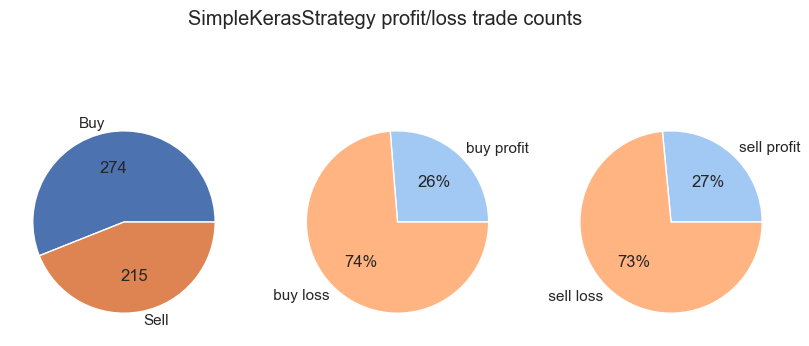

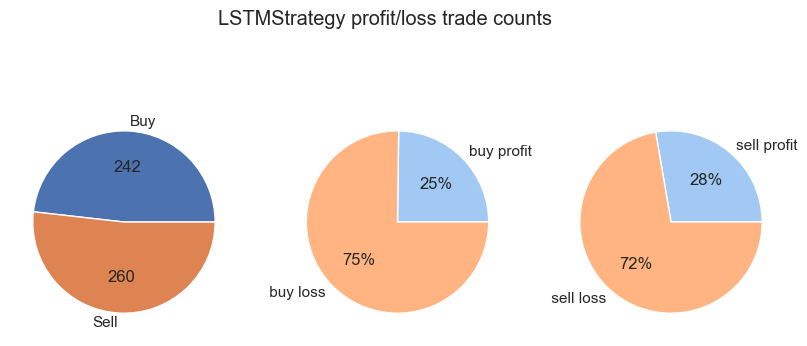

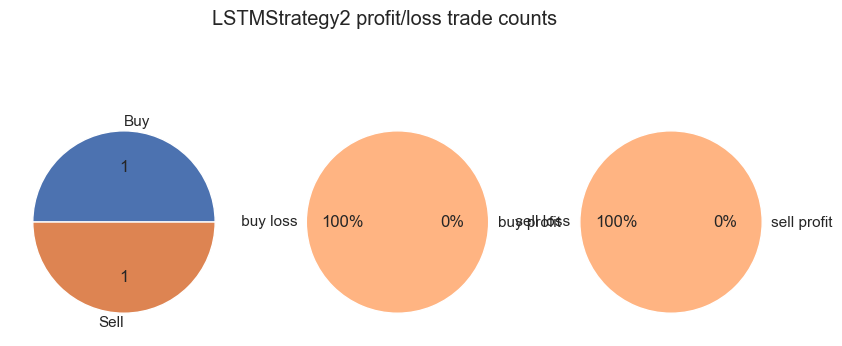

In [5]:
def plot_trade_counts(strategy, trades):
    buy_sell_counts = trades["side"].value_counts()
    total=len(trades)
    colors = sns.color_palette('pastel')[0:5]
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(plot_figsize)
    fig.suptitle(f'{strategy} profit/loss trade counts')
    # Buy/sell counts
    ax1.pie([len(trades[trades["side"]=="BUY"]),len(trades[trades["side"]=="SELL"])], 
            labels=["Buy","Sell"], \
            autopct=lambda p: '{:.0f}'.format(p * total / 100))
    # Buy profit/loss counts
    ax2.pie([len(trades[(trades["side"]=="BUY") &  (trades["profit"]>0)].index),\
            len(trades[(trades["side"]=="BUY") &  (trades["profit"]<0)].index) \
            ],
            labels=["buy profit", " buy loss"], autopct="%.0f%%", colors=colors)
    # Sell profit/loss counts
    ax3.pie([len(trades[(trades["side"]=="SELL") &  (trades["profit"]>0)].index),\
            len(trades[(trades["side"]=="SELL") &  (trades["profit"]<0)].index) \
            ],
            labels=["sell profit", " sell loss"], autopct="%.0f%%", colors=colors)
    fig.subplots_adjust(top=1)

    plt.show()



for strategy in strategies_trades:
    plot_trade_counts(strategy, strategies_trades[strategy])

## Compare strategies profits

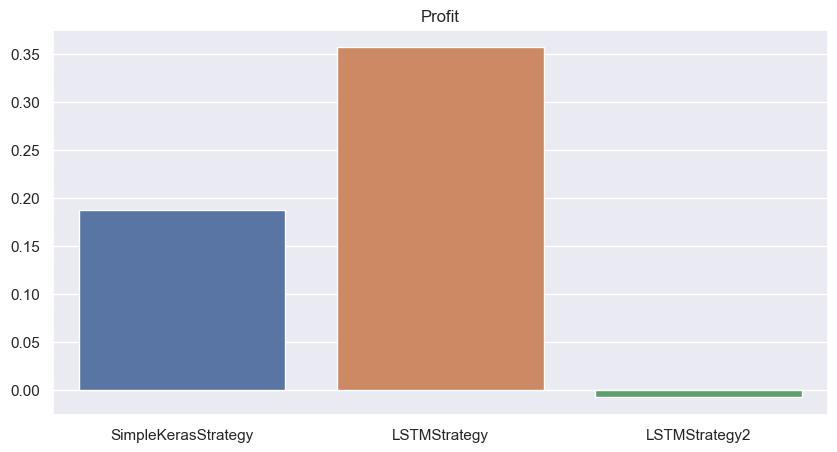

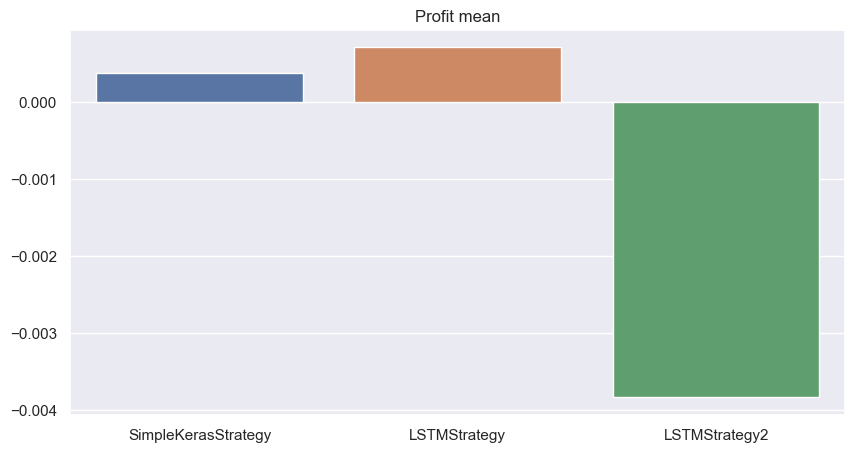

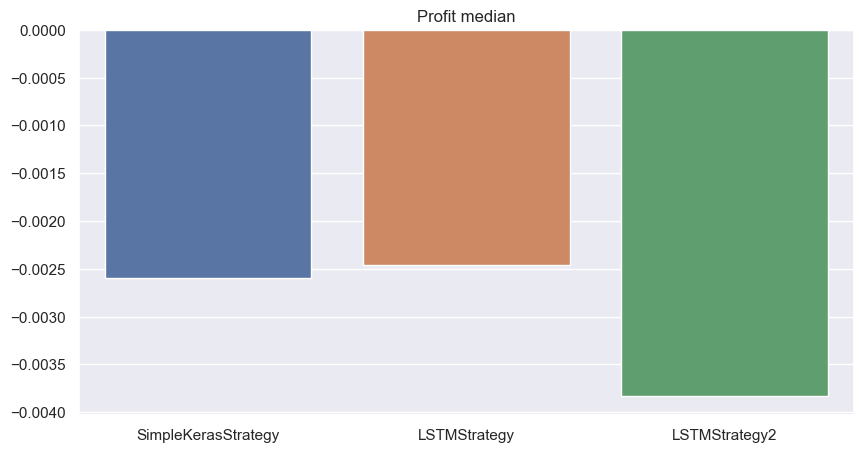

In [6]:
def plot_comparison(title, strategies_trades, y_func):
    """ Comparison bar plot: x=strategy, y=summary function for the strategy"""
    data={"strategy":[], "profit":[]}
    #strategies_data = dict([(strategy,get_trades(strategy)) for strategy in strategies])
    for strategy in strategies:
        #val = get_trades(strategy)["profit"].sum()
        trades = strategies_trades[strategy]
        val = y_func(trades)
        data["strategy"].append(strategy)
        data["profit"].append(val)
    plt.figure(figsize=plot_figsize)
    sns.barplot(data=data, x="strategy", y="profit").set_title(title)
    plt.show()
    
    
plot_comparison("Profit", strategies_trades, lambda trades: trades["profit"].sum())
plot_comparison("Profit mean", strategies_trades, lambda trades: trades["profit"].mean())
plot_comparison("Profit median", strategies_trades, lambda trades: trades["profit"].median())


### Buy, sell profit

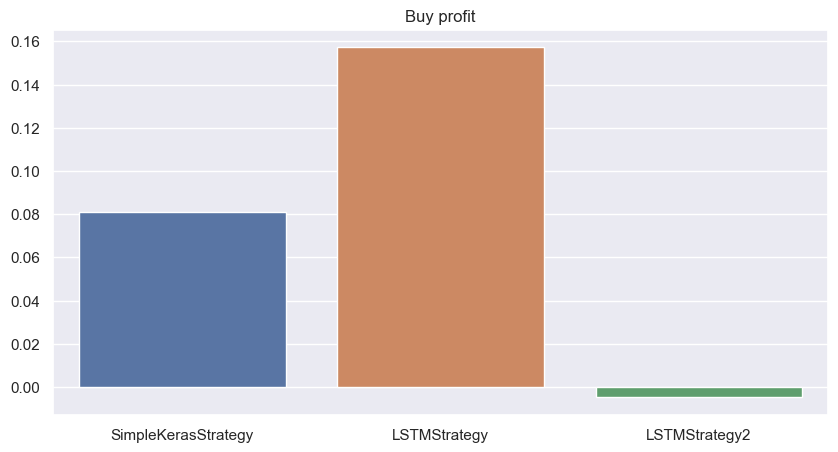

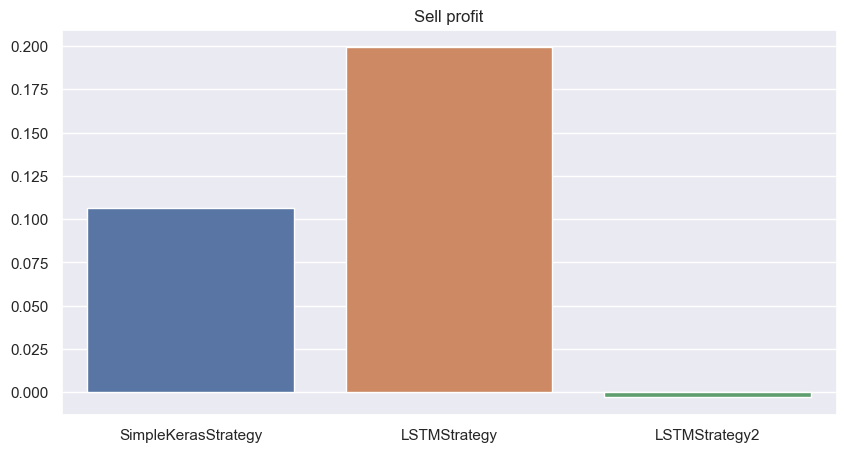

In [7]:
plot_comparison("Buy profit", strategies_trades, lambda trades: trades.loc[trades["side"]=="BUY","profit"].sum())
plot_comparison("Sell profit", strategies_trades, lambda trades: trades.loc[trades["side"]=="SELL","profit"].sum())


### Buy, sell mean profit

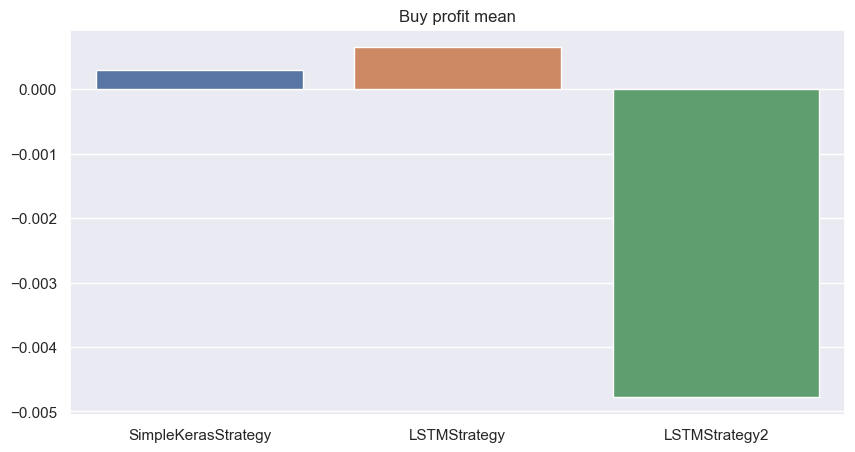

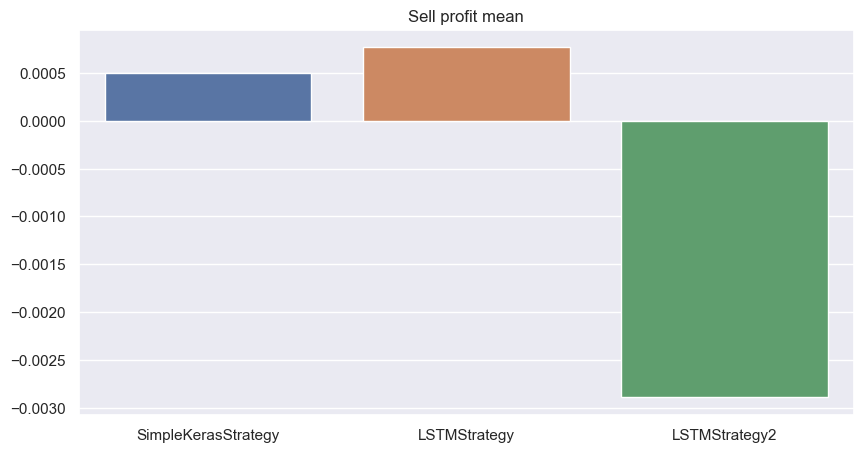

In [8]:
plot_comparison("Buy profit mean", strategies_trades, lambda trades: trades.loc[trades["side"]=="BUY","profit"].mean())
plot_comparison("Sell profit mean", strategies_trades, lambda trades: trades.loc[trades["side"]=="SELL","profit"].mean())


### Buy, sell median profit

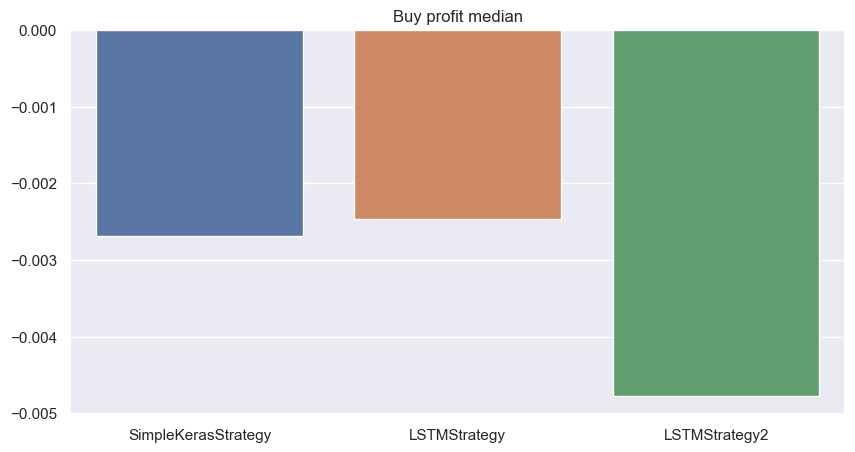

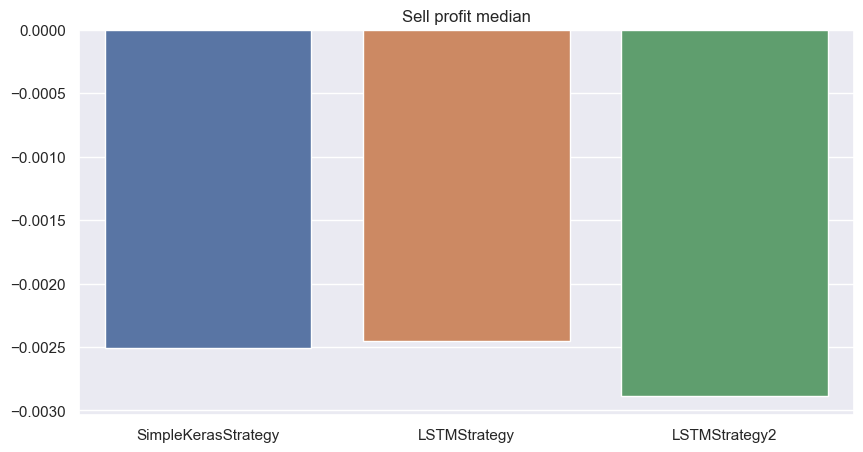

In [9]:
plot_comparison("Buy profit median", strategies_trades, lambda trades: trades.loc[trades["side"]=="BUY","profit"].median())
plot_comparison("Sell profit median", strategies_trades, lambda trades: trades.loc[trades["side"]=="SELL","profit"].median())


## Profit summary

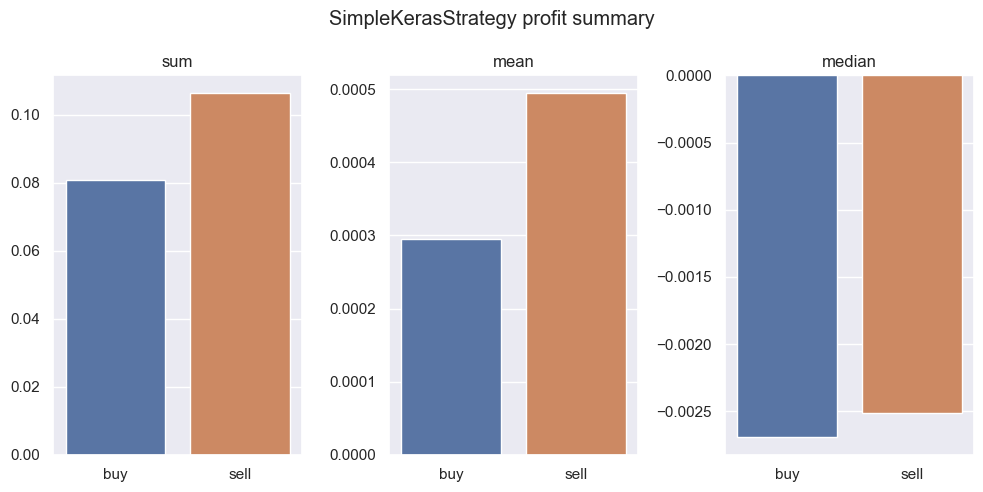

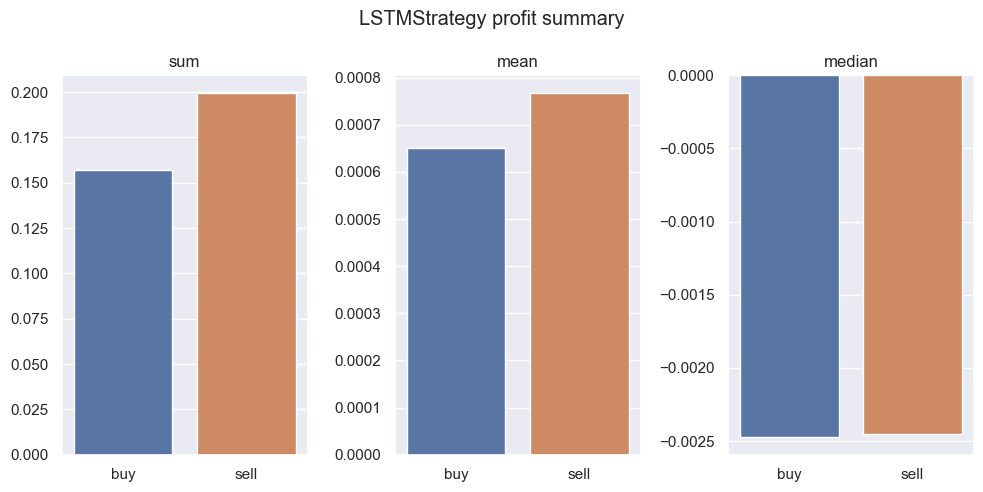

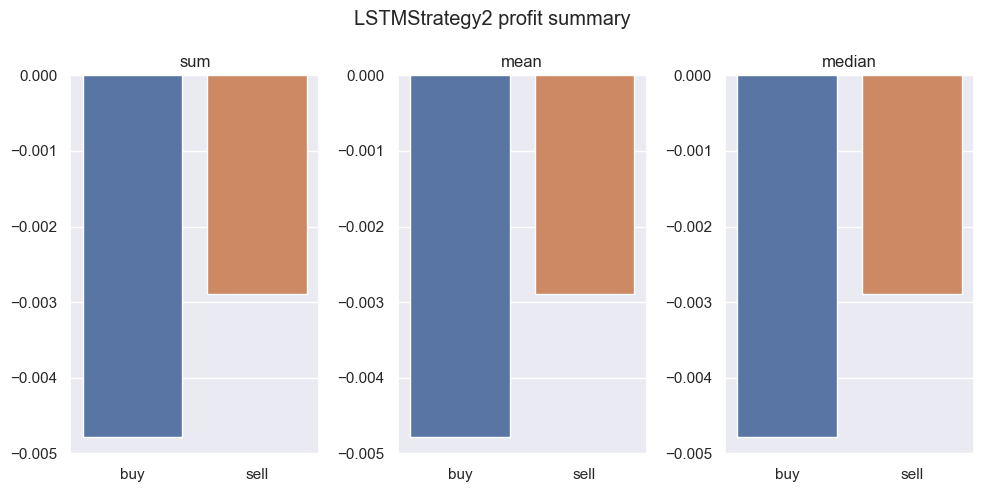

In [10]:
def plot_strategy_profit_sum(strategy, trades):
    """ Profit statistics: summary, average """
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(plot_figsize)
    fig.suptitle(f'{strategy} profit summary')
    
    buy_profit = trades.loc[trades["side"]=="BUY","profit"]
    sell_profit = trades.loc[trades["side"]=="SELL","profit"]

    # Plots
    sns.barplot(x=["buy", "sell"], y = [buy_profit.sum(), sell_profit.sum()], ax=ax1).set_title("sum")
    sns.barplot(x=["buy", "sell"], y = [buy_profit.mean(), sell_profit.mean()], ax=ax2).set_title("mean")
    sns.barplot(x=["buy", "sell"], y = [buy_profit.median(), sell_profit.median()], ax=ax3).set_title("median")
    fig.tight_layout()
    plt.show()

def plot_profit_sum(strategies_trades):
    """ Plot profit statistics for all strategies"""
    for strategy in strategies_trades:
        plot_strategy_profit_sum(strategy, strategies_trades[strategy])


        
plot_profit_sum(strategies_trades)        
